
# **Blindness Detection**

Dataset [Download](https://www.kaggle.com/competitions/aptos2019-blindness-detection/data)
A clinician has rated each image for the severity of diabetic retinopathy on a scale of 0 to 4:

0 - No DR

1 - Mild

2 - Moderate

3 - Severe

4 - Proliferative DR

Like any real-world data set, you will encounter noise in both the images and labels. Images may contain artifacts, be out of focus, underexposed, or overexposed. The images were gathered from multiple clinics using a variety of cameras over an extended period of time, which will introduce further variation.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import zipfile

# Specify the name of your dataset.zip file
zip_file_name = "/content/drive/MyDrive/train_images.zip"

# Specify the destination directory to extract the contents
destination_directory = "/content/train_images"

# Unzip the dataset.zip file to the destination directory
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(destination_directory)

# List the files in the destination directory to verify extraction
import os
os.listdir(destination_directory)


['6d6fcf49e515.png',
 '6666c4f18396.png',
 '099021fac3c9.png',
 '3fd45879afe6.png',
 '29580bed2f7d.png',
 'd18f6431ebce.png',
 '3e6bfc4d5c65.png',
 '5e7db41b3bee.png',
 'eabf421f94d0.png',
 '6165081b9021.png',
 'cd1c98ec48b1.png',
 '22d843b2bbd1.png',
 'c85b79d70079.png',
 'b8fb9f55cd6d.png',
 '6dcde47060f9.png',
 'a62ea0043aa7.png',
 '3c78bfca247b.png',
 '658ad9f09f5d.png',
 '4a558a1cd243.png',
 '9a28d4e8aef0.png',
 '101b9ebfc720.png',
 '0e82bcacc475.png',
 '72595230840c.png',
 'ffcf7b45f213.png',
 '4fecf87184e6.png',
 '65c958379680.png',
 'b187b3c93afb.png',
 'b8e20c076b03.png',
 'a5a2a7003d60.png',
 '0ac436400db4.png',
 '9b7b6e4db1d5.png',
 'e9f82b5bbaf4.png',
 '29f44aea93a4.png',
 'ad93d88c87ea.png',
 '540e4973829e.png',
 'e81f4a2fbbdc.png',
 'bde1063a5dd7.png',
 'df84e7113003.png',
 '7d1da90d3ca9.png',
 '91b7a4179ecf.png',
 '9c514d2d5b3f.png',
 'f7735b6d47f7.png',
 '40e9b5630438.png',
 'e0b5a982a018.png',
 '5e18af29d812.png',
 '7d48f8cdfb69.png',
 '349f3c0ac83e.png',
 '52dbec057cc

In [3]:
import tensorflow as tf
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [4]:
STAGES = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]
IMG_SIZE = 224
# Define paths to images and labels
train_image_dir = (
    "/content/train_images"
)
train_label_file = "/content/drive/MyDrive/train.csv"
# Load labels into a pandas dataframe
labels_df = pd.read_csv(train_label_file)

# Create a dictionary mapping image IDs to labels
label_dict = dict(zip(labels_df["id_code"], labels_df["diagnosis"]))

# Define a function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image /= 255.0
    return image
# Define a function to get the label for an image
def get_label(image_path):
    image_id = os.path.basename(image_path).split(".")[0]
    res = np.zeros(5)
    res[label_dict[image_id]] = 1
    return res

In [5]:
# Get a list of image paths
image_paths = [
    os.path.join(train_image_dir, filename) for filename in os.listdir(train_image_dir)
]
# Split the dataset into training, validation, and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths,
    [get_label(path) for path in image_paths],
    test_size=0.2,
    random_state=42,
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, random_state=42
)
# Create a dataset of image paths
train_paths_ds = tf.data.Dataset.from_tensor_slices(train_paths)
val_paths_ds = tf.data.Dataset.from_tensor_slices(val_paths)
test_paths_ds = tf.data.Dataset.from_tensor_slices(test_paths)
# Load and preprocess the images
train_images_ds_1 = train_paths_ds.map(load_and_preprocess_image)
val_images_ds_1 = val_paths_ds.map(load_and_preprocess_image)
test_images_ds_1 = test_paths_ds.map(load_and_preprocess_image)

In [6]:
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol

        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:  # image is too dark so that we crop out everything,
            return img  # return original image
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img


def circle_crop(img, sigmaX):
    """
    Create circular crop around image centre
    """
    img = img.numpy()
    img = crop_image_from_gray(img)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, depth = img.shape

    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), float(sigmaX)), -4, 0.5)
    return img

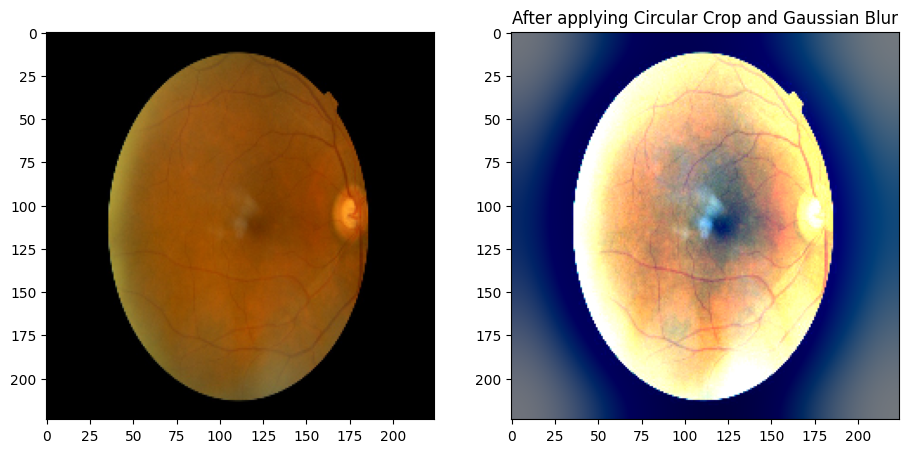

In [7]:
"""Perform Image Processing on a sample image"""
img = list(train_images_ds_1.take(1))[0]
# img = img_t
img_t = circle_crop(img, sigmaX=30)

f, axarr = plt.subplots(1, 2, figsize=(11, 11))
axarr[0].imshow(img)
axarr[1].imshow(img_t)
plt.title("After applying Circular Crop and Gaussian Blur")
plt.show()


In [8]:
# Apply the function over the dataset
train_images_ds = train_images_ds_1.map(
    lambda x: tf.py_function(circle_crop, [x, 30], tf.float32)
)
val_images_ds = val_images_ds_1.map(
    lambda x: tf.py_function(circle_crop, [x, 30], tf.float32)
)
test_images_ds = test_images_ds_1.map(
    lambda x: tf.py_function(circle_crop, [x, 30], tf.float32)
)

In [9]:
# Combine the images and labels into a single dataset
train = tf.data.Dataset.zip(
    (train_images_ds, tf.data.Dataset.from_tensor_slices(train_labels))
)
val = tf.data.Dataset.zip(
    (val_images_ds, tf.data.Dataset.from_tensor_slices(val_labels))
)
test = tf.data.Dataset.zip(
    (test_images_ds, tf.data.Dataset.from_tensor_slices(test_labels))
)
train = train.batch(8)
train = train.prefetch(4)
test = test.batch(8)
test = test.prefetch(4)
val = val.batch(8)
val = val.prefetch(4)
train.as_numpy_iterator().next()

(array([[[[ 4.3635476e-01,  4.5409638e-01,  4.8478886e-01],
          [ 4.3621349e-01,  4.5399922e-01,  4.8475844e-01],
          [ 4.3578953e-01,  4.5370775e-01,  4.8466715e-01],
          ...,
          [ 4.4664133e-01,  4.7146690e-01,  4.9557695e-01],
          [ 4.4700569e-01,  4.7166732e-01,  4.9561122e-01],
          [ 4.4712710e-01,  4.7173411e-01,  4.9562263e-01]],
 
         [[ 4.3627721e-01,  4.5403990e-01,  4.8477089e-01],
          [ 4.3613580e-01,  4.5394269e-01,  4.8474044e-01],
          [ 4.3571147e-01,  4.5365095e-01,  4.8464909e-01],
          ...,
          [ 4.4657591e-01,  4.7143370e-01,  4.9557355e-01],
          [ 4.4694060e-01,  4.7163427e-01,  4.9560785e-01],
          [ 4.4706213e-01,  4.7170109e-01,  4.9561927e-01]],
 
         [[ 4.3604445e-01,  4.5387048e-01,  4.8471695e-01],
          [ 4.3590268e-01,  4.5377302e-01,  4.8468643e-01],
          [ 4.3547726e-01,  4.5348057e-01,  4.8459488e-01],
          ...,
          [ 4.4637969e-01,  4.7133404e-01,  4.955

In [10]:
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
WARMUP_EPOCHS = 3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
def build_model():
    # Load the pre-trained ResNet50 model
    base_model = ResNet50(
        weights="imagenet", include_top=False, input_shape=(224, 224, 3)
    )

    # Add a global average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Add a fully connected layer with 2048 neurons and ReLU activation
    x = Dense(2048, activation="relu")(x)

    # Dropout by 0.5
    x = Dropout(0.5)(x)

    # Add an output layer with 5 neurons (for the 5 classes) and softmax activation
    predictions = Dense(5, activation="softmax")(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model
model = build_model()
for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [11]:
# Warm up the model to make our new layers get some initial training
model.compile(
    optimizer=optimizers.Adam(lr=WARMUP_LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history_warmup = model.fit(train, validation_data=val, epochs=WARMUP_EPOCHS)

Epoch 1/3
293/293 [==============================] - 267s 858ms/step - loss: 1.2040 - accuracy: 0.5845 - val_loss: 0.8967 - val_accuracy: 0.6894
Epoch 2/3
293/293 [==============================] - 227s 774ms/step - loss: 0.9678 - accuracy: 0.6456 - val_loss: 0.9082 - val_accuracy: 0.7048
Epoch 3/3
293/293 [==============================] - 227s 777ms/step - loss: 0.9244 - accuracy: 0.6627 - val_loss: 0.8708 - val_accuracy: 0.7031


In [12]:
# now make all layers trainable
for layer in model.layers:
    layer.trainable = True
es = EarlyStopping(
    monitor="val_loss", mode="min", patience=5, restore_best_weights=True, verbose=1
)
rlrop = ReduceLROnPlateau(
    monitor="val_loss", mode="min", patience=3, factor=0.5, min_lr=1e-6, verbose=1
)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [13]:
# now make all layers trainable
for layer in model.layers:
    layer.trainable = True
es = EarlyStopping(
    monitor="val_loss", mode="min", patience=5, restore_best_weights=True, verbose=1
)
rlrop = ReduceLROnPlateau(
    monitor="val_loss", mode="min", patience=3, factor=0.5, min_lr=1e-6, verbose=1
)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [14]:
history_finetunning = model.fit(
    train, validation_data=val, epochs=40, callbacks=callback_list, verbose=1
)

Epoch 1/40
293/293 [==============================] - 283s 811ms/step - loss: 0.3820 - accuracy: 0.6678 - val_loss: 0.4858 - val_accuracy: 0.5205 - lr: 0.0010
Epoch 2/40
293/293 [==============================] - 274s 938ms/step - loss: 0.2719 - accuracy: 0.7203 - val_loss: 0.4019 - val_accuracy: 0.5495 - lr: 0.0010
Epoch 3/40
293/293 [==============================] - 276s 943ms/step - loss: 0.2490 - accuracy: 0.7408 - val_loss: 0.2662 - val_accuracy: 0.7150 - lr: 0.0010
Epoch 4/40
293/293 [==============================] - 281s 962ms/step - loss: 0.2347 - accuracy: 0.7558 - val_loss: 0.2658 - val_accuracy: 0.7287 - lr: 0.0010
Epoch 5/40
293/293 [==============================] - 233s 796ms/step - loss: 0.2227 - accuracy: 0.7532 - val_loss: 0.2406 - val_accuracy: 0.7457 - lr: 0.0010
Epoch 6/40
293/293 [==============================] - 250s 853ms/step - loss: 0.2143 - accuracy: 0.7686 - val_loss: 0.3003 - val_accuracy: 0.7321 - lr: 0.0010
Epoch 7/40
293/293 [==========================

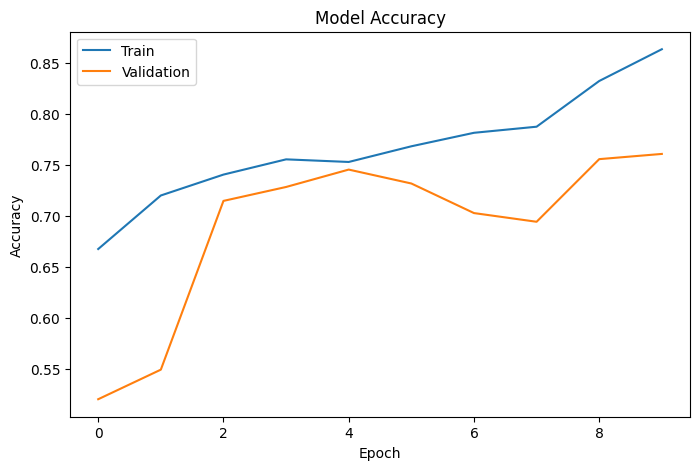

In [15]:

plt.figure(figsize=(8, 5))

plt.plot(history_finetunning.history["accuracy"])
plt.plot(history_finetunning.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.gca().ticklabel_format(axis="both", style="plain", useOffset=False)
plt.show()

In [16]:
model.save("blindnessdetection.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# loading the model later
from tensorflow.keras.models import load_model

model = load_model("blindnessdetection.h5")

In [18]:
test_iter = test.as_numpy_iterator()
test_plot = test_iter.next()
pred = model.predict(test_plot[0])

1/1 [==============================] - 2s 2s/step


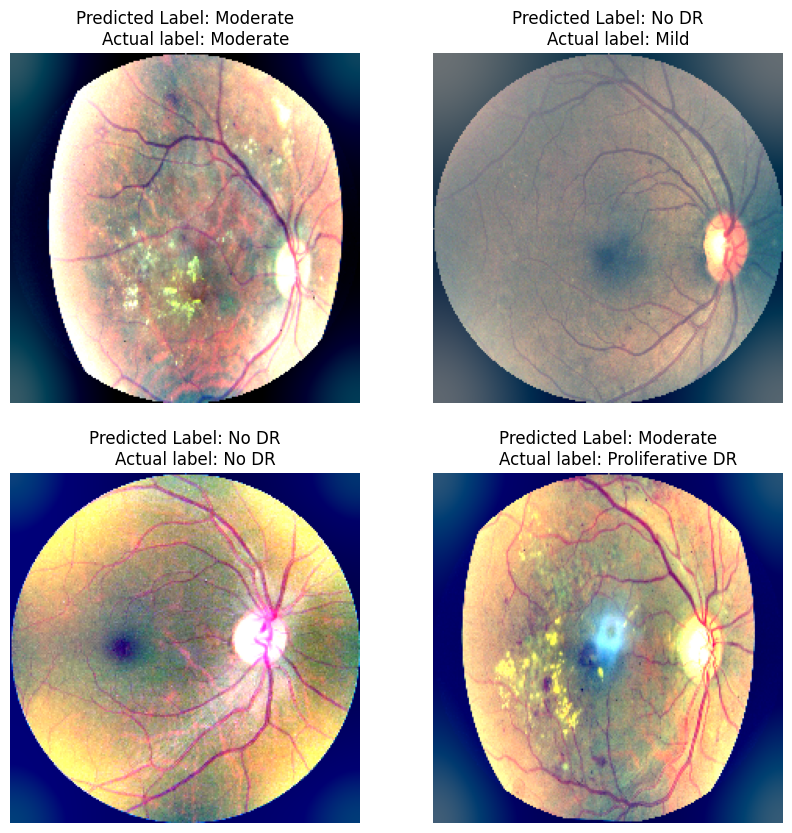

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for n, ax in enumerate(axs):
    ax.imshow(test_plot[0][n])
    ax.set_title(
        f"""Predicted Label: {STAGES[np.argmax(pred[n])]}
    Actual label: {STAGES[np.argmax(test_plot[1][n])]}"""
    )
    ax.axis("off")

plt.show()